In [2]:
import numpy as np
import pickle
from sklearn.preprocessing import MinMaxScaler
from sklearn.impute import SimpleImputer
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report

## Carga de datos de índices acústicos

In [3]:
with open('./ais_perRow.pickle', 'rb') as handle:
    unserialized_data = pickle.load(handle)
    X_ai = unserialized_data['X']
    y_ai = unserialized_data['y']
    print('Datos Cargados!')

Datos Cargados!


In [4]:
print(f'Tamaño matriz de características: {X_ai.shape}')
print(f'Tamaño vector de etiquetas: {y_ai.shape}')

Tamaño matriz de características: (71497, 60)
Tamaño vector de etiquetas: (71497, 1)


In [5]:
print(np.unique(y_ai, return_counts=True)) # Las etiquetas son 0, 1 y 2. Hacen referencia a lo siguiente:
NumtoCover = {0: 'Pastizal', 1:'Sabana', 2:'Bosque'}

(array([0., 1., 2.]), array([41957, 14994, 14546], dtype=int64))


### Imputación y normalización de datos

In [6]:
nan_indices = np.isnan(X_ai)
num_nan_per_column = np.sum(nan_indices, axis=0)
total_nan = np.sum(nan_indices)
print("Número total de valores NaN en los datos originales:", total_nan)
print("Número de valores NaN por columna:")
print(num_nan_per_column)

Número total de valores NaN en los datos originales: 481
Número de valores NaN por columna:
[  0   0   0   0   0   0   0   0   0   0   0   0 478   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   3   0   0   0   0   0   0   0
   0   0   0   0   0   0]


In [7]:
selected_indices = np.where((y_ai == 1) | (y_ai == 2))[0]
X_selected = X_ai[selected_indices]
y_selected = y_ai[selected_indices]

In [8]:
X_train, X_temp, y_train, y_temp = train_test_split(X_selected, y_selected, test_size=0.3, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)

In [9]:
imputer = SimpleImputer(strategy='mean')
X_train_imputed = imputer.fit_transform(X_train)
X_val_imputed = imputer.transform(X_val)

scaler = MinMaxScaler()
X_train_imputed = scaler.fit_transform(X_train_imputed)
X_val_imputed = scaler.transform(X_val_imputed)

### Entrenamiento del modelo

In [10]:
model = LogisticRegression(max_iter = 500)
model.fit(X_train_imputed, np.squeeze(y_train));

### Resultados en Validación

In [11]:
y_pred = model.predict(X_val_imputed)
print("Reporte de clasificación en el conjunto de validación:")
print(classification_report(y_val, y_pred))

Reporte de clasificación en el conjunto de validación:
              precision    recall  f1-score   support

         1.0       0.60      0.66      0.63      2251
         2.0       0.60      0.54      0.57      2180

    accuracy                           0.60      4431
   macro avg       0.60      0.60      0.60      4431
weighted avg       0.60      0.60      0.60      4431



##  Local Interpretable Model-Agnostic Explanations (LIME)
https://github.com/marcotcr/lime

In [12]:
# ! pip install lime

In [13]:
import lime
from lime import lime_tabular

In [14]:
feature_names = ['ZCR','MEANt', 'VARt', 'SKEWt', 'KURTt',
               'LEQt','BGNt', 'SNRt','MED', 'Ht','ACTtFraction', 'ACTtCount',
               'ACTtMean','EVNtFraction', 'EVNtMean', 'EVNtCount',
               'MEANf','VARf','SKEWf','KURTf','NBPEAKS','LEQf',
                'ENRf','BGNf','SNRf','Hf', 'EAS','ECU','ECV','EPS','EPS_KURT','EPS_SKEW','ACI',
                'NDSI','rBA','AnthroEnergy','BioEnergy','BI','ROU','ADI','AEI','LFC','MFC','HFC',
                'ACTspFract','ACTspCount','ACTspMean', 'EVNspFract','EVNspMean','EVNspCount',
                'TFSD','H_Havrda','H_Renyi','H_pairedShannon', 'H_gamma', 'H_GiniSimpson','RAOQ',
                'AGI','ROItotal','ROIcover']

In [15]:
interpretor = lime_tabular.LimeTabularExplainer(
    training_data=X_train_imputed,
    feature_names=feature_names,
    mode='classification',
    class_names=['Sabana', 'Bosque'],
    feature_selection='highest_weights',
    discretize_continuous=True
)

In [22]:
idx = 10
print(f"Etiqueta real: {NumtoCover[y_val[idx,0]]}")

exp = interpretor.explain_instance(
    data_row=X_val_imputed[idx], ##new data
    predict_fn=model.predict_proba,
    # num_features=5,
    # top_labels=1
)

exp.show_in_notebook(show_table=True, show_all=False)

Etiqueta real: Bosque


## SHapley Additive exPlanations (SHAP)
https://github.com/shap/shap

In [17]:
# !pip install shap

Gráfica de importancia por Variable - Interpretación Global


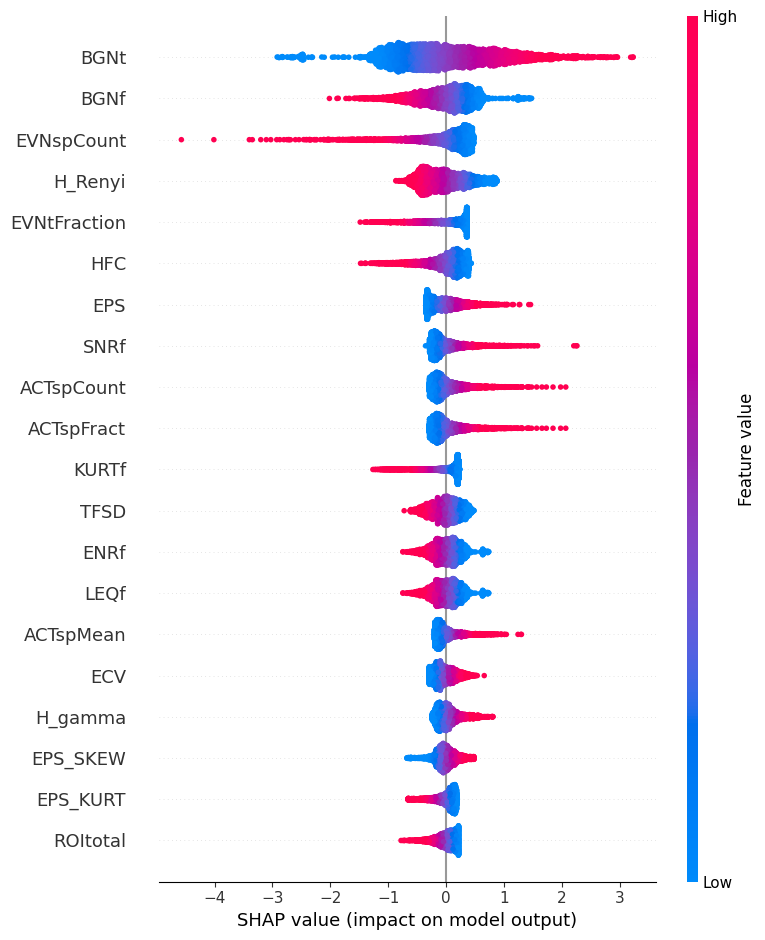

In [27]:
import shap
import matplotlib.pyplot as plt

explainer = shap.Explainer(
    model, X_train_imputed, feature_names=feature_names
)
shap_values = explainer(X_val_imputed)
shap.initjs()

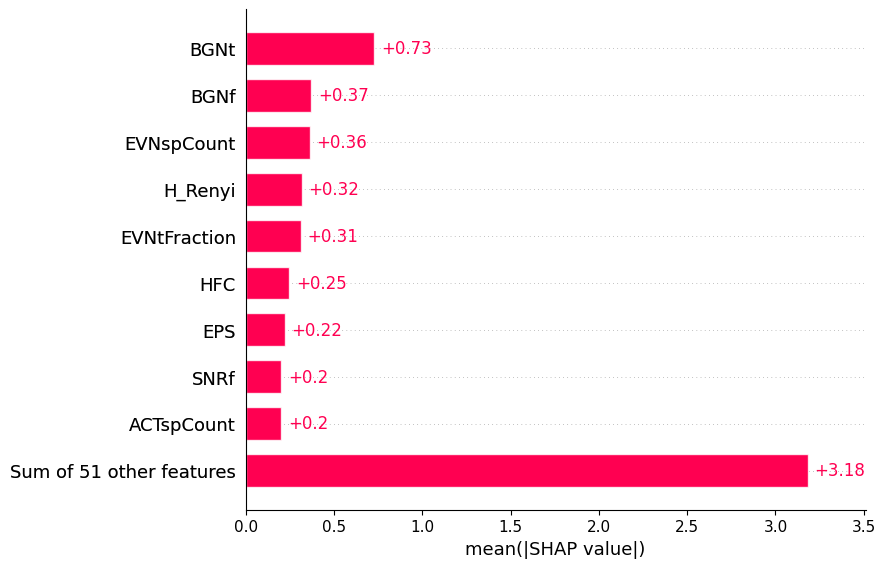

In [131]:
shap.plots.bar(shap_values)

Gráfica de importancia por Variable - Interpretación Global


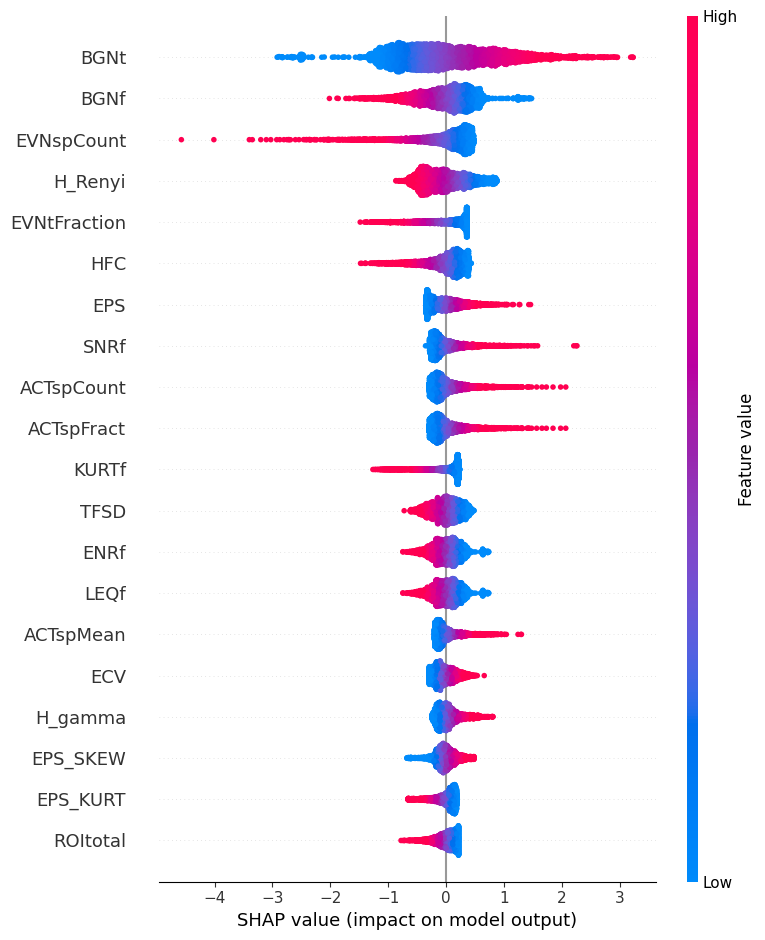

In [132]:
print("Gráfica de importancia por Variable - Interpretación Global")
figure = plt.figure()
shap.summary_plot(shap_values, X_val_imputed)

In [129]:
ind = 11
print(y_val[ind])
print(model.predict((X_val_imputed[ind]).reshape(-1, 60)))
shap.plots.force(shap_values[ind])

[2.]
[2.]


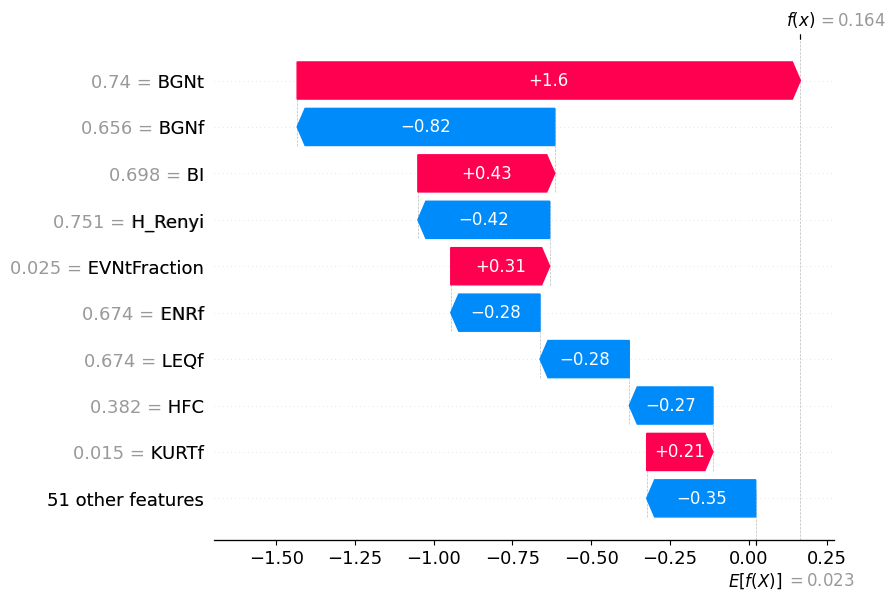

In [130]:
shap.plots.waterfall(shap_values[ind])

In [128]:
shap.plots.force(shap_values[:100])